In [33]:
import Pkg; Pkg.add("LsqFit")

   Resolving package versions...
   Installed Calculus ──────────────── v0.5.1
   Installed Rmath_jll ─────────────── v0.4.0+0
   Installed PDMats ────────────────── v0.11.29
   Installed NLSolversBase ─────────── v7.8.3
   Installed LsqFit ────────────────── v0.15.0
   Installed StatsFuns ─────────────── v1.3.0
   Installed HypergeometricFunctions ─ v0.3.23
   Installed FiniteDiff ────────────── v2.21.1
   Installed ConstructionBase ──────── v1.5.4
   Installed Setfield ──────────────── v1.1.1
   Installed DualNumbers ───────────── v0.6.8
   Installed QuadGK ────────────────── v2.9.1
   Installed FillArrays ────────────── v1.7.0
   Installed ArrayInterface ────────── v7.5.1
   Installed Rmath ─────────────────── v0.7.1
   Installed Distributions ─────────── v0.25.103
    Updating `C:\Users\Caio\.julia\environments\v1.9\Project.toml`
  [2fda8390] + LsqFit v0.15.0
    Updating `C:\Users\Caio\.julia\environments\v1.9\Manifest.toml`
  [4fba245c] + ArrayInterface v7.5.1
  [49dc2e85] + Calc

### Problema 1 (formulação matemática de problema geométrico): 

Determine o triângulo de área mínima contendo dois círculos de raio um que são disjuntos (i.e., <b> não </b> se intersetam). Para assegurar uniformidade de notação (e facilitar a correção), sejam os vértices do triângulo localizados nos pontos $(0,0), (x_1,0),(x_2,x_3)$ e os centros dos círculos no triângulo $(x_4,x_5)$, $(x_6,x_7)$. Formule como problema de otimização, explicitando função objetivo, variáveis de decisão, e restrições. A sua formulação resultou em qual tipo de problema de otimização? 

<b>Sugestão</b>: Utilize a formula para a distância entre um ponto e uma reta discutida na aula 4 (slide 4-17).

In [3]:
using JuMP
using Ipopt
using LinearAlgebra

# Inicialização do modelo de otimização
m = Model(Ipopt.Optimizer)

# Variáveis de decisão
@variable(m, x[1:7] >= 0)

# Valores iniciais das variáveis
set_start_value.(x, [0, 0, 0, 0, 0, 0, 0])

# Restrição: A distância entre x4, x5 e x6, x7 deve ser 2r = 2
@NLconstraint(m, (x[4] - x[6])^2 + (x[5] - x[7])^2 >= 4)

# Restrições das paredes do triângulo: a distância entre o centro dos círculos e qualquer parede deve ser > 1
# Reescrevendo a fórmula da distância, temos: r = (b - a^Ty)/norm(a). Portanto, r >= 1
# Vetores normais às paredes
a1 = [0, -1]
a2 = [x[3], x[1] - x[2]]
a3 = [-x[3], x[2]]

# b1, b2 e b3
b1 = 0
b2 = x[3] * x[1]
b3 = 0

# Restrições
for (a, b) in zip([a1, a2, a3], [b1, b2, b3])
    # Restrição para o Círculo 1
    @NLconstraint(m, (b - (a[1]*x[4] + a[2]*x[5])) / ((a[1]^2 + a[2]^2)^0.5) >= 1)
    # Restrição para o Círculo 2
    @NLconstraint(m, (b - (a[1]*x[6] + a[2]*x[7])) / ((a[1]^2 + a[2]^2)^0.5) >= 1)
end

# Restrições adicionais para garantir que os círculos estão contidos no triângulo
@constraint(m, x[4] <= x[3])
@constraint(m, x[5] >= 0)
@constraint(m, x[6] >= 0)
@constraint(m, x[7] <= x[3])

# Função objetivo: Minimizar a área do triângulo
@objective(m, Min, x[1] * x[3] / 2)

# Otimização do modelo
optimize!(m)

# Exibição dos resultados
println("Estado de término: ", termination_status(m))
println("Valores ótimos das variáveis: ", value.(x))
println("Distância entre os centros dos círculos: ", ((value(x[4]) - value(x[6]))^2 + (value(x[5]) - value(x[7]))^2)^0.5)
println("Valor ótimo da função objetivo: ", objective_value(m))

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       32
Number of nonzeros in Lagrangian Hessian.............:       57

Total number of variables............................:        7
                     variables with only lower bounds:        7
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       11
        inequality constraints with only lower bounds:        9
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.9999900e-05 4.00e+00 1.84e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

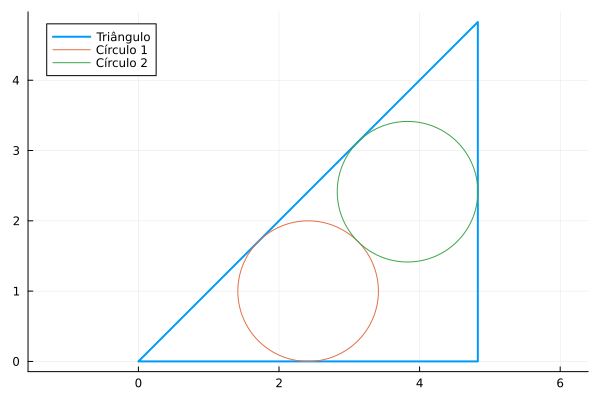

In [2]:
using Plots

# Dados após a otimização
x_opt = value.(x)

# Coordenadas dos vértices do triângulo
x1, x2, x3 = x_opt[1], x_opt[2], x_opt[3]

# Coordenadas dos centros dos círculos
x4, x5 = x_opt[4], x_opt[5]
x6, x7 = x_opt[6], x_opt[7]

# Coordenadas dos vértices do triângulo
vertices_x = [0, x1, x2, 0]
vertices_y = [0, 0, x3, 0]

# Ângulo para plotar as circunferências
θ = LinRange(0, 2π, 100)

# Coordenadas dos pontos das circunferências
circle1_x = x4 .+ cos.(θ)
circle1_y = x5 .+ sin.(θ)

circle2_x = x6 .+ cos.(θ)
circle2_y = x7 .+ sin.(θ)

# Configurando a figura usando Plots
plot(vertices_x, vertices_y, label="Triângulo", lw=2)
plot!(circle1_x, circle1_y, label="Círculo 1", lw=1)
plot!(circle2_x, circle2_y, label="Círculo 2", lw=1)

# Configurações adicionais do gráfico
plot!(aspect_ratio=:equal)
plot!(legend=true)

### Problema 2 (Ajuste de uma curva constante por pedaços)

Considere um sinal ruidoso (sequência de pontos) que é aproximadamente constante por pedaços, como ilustrado na Figura abaixo:
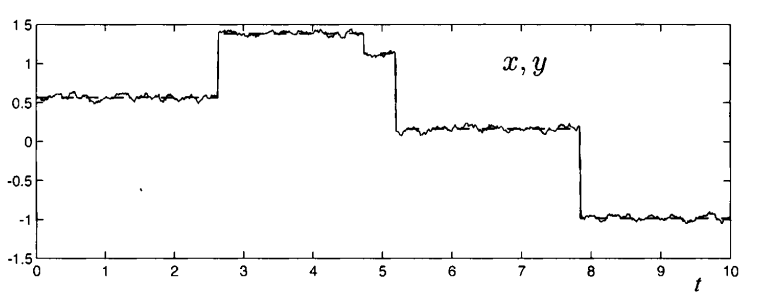

Na figura, $x \in R^n$ representa o sinal desconhecido constante por pedaços e $y$ representa a versão ruidosa medida dd sinal $x$ (ou seja, $y$ é o sinal original $x$ mais ruido). Dado $y$, gostaríamos de computar uma estimativa $\hat{x}$ do sinal original $x$ tal que $\hat{x}$ tenha o menor número de mudanças em instantes consecutivos. Modelamos esta exigência minimizando o número de elementos não-nulos do vetor de diferenças $D\hat{x}$, sendo $D \in R^{(n-1)\times n}$ a matriz de diferenças
$$
D = \begin{bmatrix} 
-1 & 1 & 0 & \cdots & 0 \\
0 & -1 & 1 & \vdots & 0 \\
\vdots & & & \ddots & \\
0 & \cdots & 0 & -1 & 1
\end{bmatrix}
$$
o que significa que $D\hat{x} = \left[\hat{x}_2 - \hat{x}_1, \hat{x}_3 - \hat{x}_2, \ldots , \hat{x}_n - \hat{x}_{n-1}\right]^T$. Com esta definição de $D$, chega-se ao problema de otimização:
\begin{align}
& \min_{\hat{x}} \|y - \hat{x}\|_2^2 \\
& \text{s.a.}~\text{card} (D\hat{x}) \leq k
\end{align}
sendo card($D\hat{x}$) = número de elementos não-nulos de $D\hat{x}$, e $k$ uma estimativa do número de saltos (degraus) no sinal. Este problema é difícil de resolver, pois $\text{card}(\cdot)$ é uma função descontínua, e pode ser substituído pela versão regularizada
\begin{equation}
\min_{\hat{x}} \|y - \hat{x}\|_2^2  + \gamma \| (D\hat{x}) \|_p
\end{equation}
sendo $\gamma$ o parâmetro de regularização. Resolva o problema regularizado para $p = 1, 2$:

- indicando claramente que tipo de problema você está resolvendo (LP, QP, QCQP etc.)
- plotando os gráficos do sinal reconstruído (=estimado) e o sinal original, comentando as características das soluções obtidas.

Gere seu sinal de ruído considerando que o sinal original é descrito por:
$$
x = \left\{
\begin{array}{l}
k_1 = 0.5,~\text{se}~t \in [0,2.8) \\
k_2 = 1.5,~\text{se}~t \in [2.8,4.8) \\
k_3 = 1.1,~\text{se}~t \in [4.8,5.2) \\
k_4 = 0.1,~\text{se}~t \in [5.2,7.9)\\
k_5 = -1,~\text{se}~t \in  [7.9,10]
\end{array}
\right.
$$
e que o sinal ruidoso $y$ é gerado a partir de $x$, acrescentando um ruido gaussiano de média $k_i$ e variância $0.01$ ao $i$-ésimo trecho constante de $x$. Forneça o par de sinais $x,y$ no *notebook* entregue. Para o problema proposto, trabalhe com 100 amostras igualmente espaçadas dos sinais contínuos gerados.

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      594
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      199
                     variables with only lower bounds:       99
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      198
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      198

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6875249e+01 0.00e+00 3.07e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

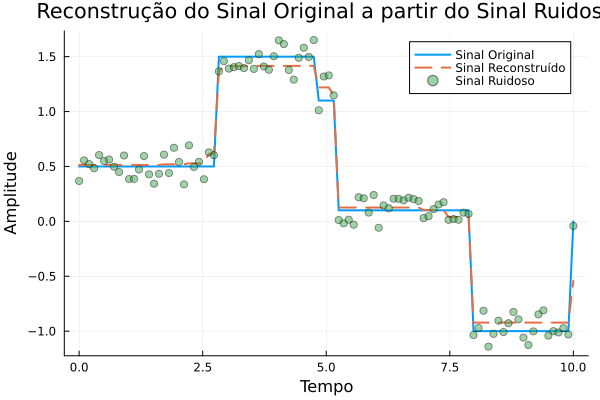

In [69]:
using JuMP
using Ipopt
using LinearAlgebra
using Plots

# Função para gerar sinais x e y
function gerar_sinais()
    t = collect(range(0, stop=10, length=100))
    x = zeros(length(t))
    
    # Definição dos intervalos e valores constantes
    intervalos = [0, 2.8, 4.8, 5.2, 7.9, 10]
    constantes = [0.5, 1.5, 1.1, 0.1, -1]
    
    for i in 1:length(intervalos)-1
        mask = (intervalos[i] .<= t .< intervalos[i+1])
        x[mask] .= constantes[i]
    end
    
    # Adicionando ruído gaussiano
    ruído = randn(length(t)) * 0.1  # Variância = 0.01
    y = x + ruído
    
    return x, y, t
end

# Gerar sinais x e y
x_real, y, t = gerar_sinais()

#termo regularizador
reg = 0.9

# Inicialização do modelo de otimização
m = Model(Ipopt.Optimizer)

# Variáveis de decisão
@variable(m, x_hat[1:length(t)])
@variable(m, d[1:length(t)-1] >= 0)

# Função objetivo: Minimizar a norma-2 do erro e penalizar desvios do sinal original
@objective(m, Min, sum((y - x_hat).^2) + reg*sum(d))

# Restrição de cardinalidade regularizada (p = 1)
@constraint(m, x_hat[1:end-1] - x_hat[2:end] .<= d)
@constraint(m, x_hat[2:end] - x_hat[1:end-1] .<= d)

# Otimização do modelo
optimize!(m)

# Sinal reconstruído
x_hat_result = value.(x_hat)

# Plotagem dos sinais
plot(t, x_real, label="Sinal Original", linewidth=2)
plot!(t, x_hat_result, label="Sinal Reconstruído", linewidth=2, linestyle=:dash, xlabel="Tempo", ylabel="Amplitude")
scatter!(t, y, label="Sinal Ruidoso", alpha=0.5)
title!("Reconstrução do Sinal Original a partir do Sinal Ruidoso")

#O problema é um QP, pois não possui restrições não-lineares e a função objetivo é quadrática

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      594
Number of nonzeros in Lagrangian Hessian.............:      199

Total number of variables............................:      199
                     variables with only lower bounds:       99
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      198
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      198

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4306516e+01 0.00e+00 3.23e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

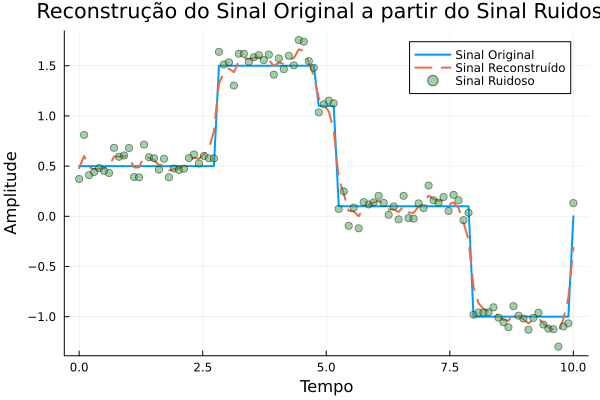

In [98]:
using JuMP
using Ipopt
using LinearAlgebra
using Plots

# Função para gerar sinais x e y
function gerar_sinais()
    t = collect(range(0, stop=10, length=100))
    x = zeros(length(t))
    
    # Definição dos intervalos e valores constantes
    intervalos = [0, 2.8, 4.8, 5.2, 7.9, 10]
    constantes = [0.5, 1.5, 1.1, 0.1, -1]
    
    for i in 1:length(intervalos)-1
        mask = (intervalos[i] .<= t .< intervalos[i+1])
        x[mask] .= constantes[i]
    end
    
    # Adicionando ruído gaussiano
    ruído = randn(length(t)) * 0.1  # Variância = 0.01
    y = x + ruído
    
    return x, y, t
end

# Gerar sinais x e y
x_real, y, t = gerar_sinais()

# Inicialização do modelo de otimização
m = Model(Ipopt.Optimizer)

# Variáveis de decisão
@variable(m, x_hat[1:length(t)])
@variable(m, d[1:length(t)-1] >= 0)

#termo regularizador
reg = 0.9

# Função objetivo: Minimizar a norma-2 do erro e penalizar desvios do sinal original
@objective(m, Min, sum((y - x_hat).^2) + reg*sum(d.^2))  # Use sum(d.^2) for L2 norm penalty

# Restrição de cardinalidade regularizada (p = 2 for L2 norm)
@constraint(m, x_hat[1:end-1] - x_hat[2:end] .<= d)
@constraint(m, x_hat[2:end] - x_hat[1:end-1] .<= d)

# Otimização do modelo
optimize!(m)

# Sinal reconstruído
x_hat_result = value.(x_hat)

# Plotagem dos sinais
plot(t, x_real, label="Sinal Original", linewidth=2)
plot!(t, x_hat_result, label="Sinal Reconstruído", linewidth=2, linestyle=:dash, xlabel="Tempo", ylabel="Amplitude")
scatter!(t, y, label="Sinal Ruidoso", alpha=0.5)
title!("Reconstrução do Sinal Original a partir do Sinal Ruidoso")

#É um NLP, um problema de mínimos quadrados não-linear com restrições lineares e um termo regularizador

### Problema 3 (Regressão $L_2$ versus regressão $L_1$):
É comum encontrar conjuntos de dados contendo *outliers*, ou seja, dados ruins oriundos de erro experimental, ruido alto ou malfuncionamento de sensores. Considere por exemplo o seguinte conjunto de 15 pares $(x,y)$ de pontos experimentais:


|x |	1 |	2 |	3 |	4 |	5 |	6 |	7 |	8 |	9 |	10 |	11 |	12 |	13 |	14 |	15 |
|--|------|---|---|---|---|---|---|---|---|----|-------|-------|-------|-------|-------|
|y |	6.31 |	3.78 |	24 |	1.71 |	2.99 |	4.53 |	2.11 |	3.88 |	4.67 |	4.25 |	2.06 |	23 |	1.58 |	2.17 |	0.02  |

Os valores de $y$ correspondentes a $x=3$ and $x=12$ são outliers porque estão muito distantes do intervalo de valores esperado no experimento.

(a) Compute a reta de melhor ajuste usando um custo $L_2$ cost (i.e., mínimos quadrados). Ou seja, encontre $a$ e $b$ that que minimizem a expressão:
$$
	L_2~\mbox{custo}:~\sum_{i=1}^{15} (y_i - ax_i - b)^2
$$

Repita o cálculo da reta de melhor ajuste, porém, desta vez, exclua os outliers do conjunto de dados. No mesmo plot, mostre os dados (todos) e ambas retas de melhor ajuste. Explique a diferença entre as duas retas de melhor ajuste.

(b) Nem sempre é possível remover outliers manualmente. Vamos investigar um método auotmático de reduzir o efeito de outliers, através da troca da função objetivo. Encontre a reta de melhor ajuste de novo (**sem** retirar os outliers), porém desta vez utilize a função de custo $L_1$:
$$
	L_1~\mbox{custo}:~\sum_{i=1}^{15} \left| y_i - ax_i - b \right|
$$
Plote os dados bem como a reta de melhor ajuste $L_1$. O que você observa sobre a influência de outliers na reta de melhor ajuste $L_1$? O custo $L_1$ lida melhor com outliers do que o método de mínimos quadrados? Explique sua resposta. 

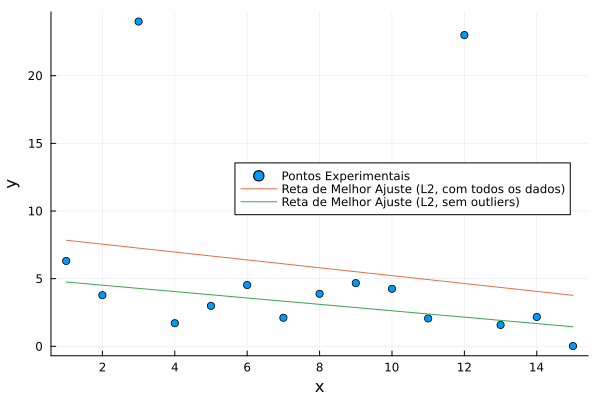

In [91]:
# Problema 3(a)

#A reta contendo todos os pontos é mais afetada pelos valores outliers, deformando a resposta. O melhor ajuste é feito
#sem o uso dos dados outliers, aproximando-se melhor do comportamento típico dos dados.


using Plots

# Dados de entrada
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

# Função para calcular os coeficientes 'a' e 'b' pelo método dos mínimos quadrados
function ajuste_L2(x, y)
    n = length(x)
    A = [x ones(n)]
    coef = A \ y
    return coef[1], coef[2]
end

# Calcula os coeficientes 'a' e 'b' para o ajuste L2 (com todos os dados)
a_L2, b_L2 = ajuste_L2(x, y)

# Excluindo os outliers (x=3 e x=12)
x_sem_outliers = [x[i] for i in 1:15 if i ∉ [3, 12]]
y_sem_outliers = [y[i] for i in 1:15 if i ∉ [3, 12]]

# Calcula os coeficientes 'a' e 'b' para o ajuste L2 (sem outliers)
a_L2_sem_outliers, b_L2_sem_outliers = ajuste_L2(x_sem_outliers, y_sem_outliers)

# Calcula os valores previstos pela reta de melhor ajuste (com todos os dados)
y_previsto = a_L2 * x .+ b_L2

# Calcula os valores previstos pela reta de melhor ajuste (sem outliers)
y_previsto_sem_outliers = a_L2_sem_outliers * x .+ b_L2_sem_outliers

# Plot dos pontos, das retas de melhor ajuste (com todos os dados e sem outliers)
Plots.scatter(x, y, label="Pontos Experimentais", legend=:right)
Plots.plot!(x, y_previsto, label="Reta de Melhor Ajuste (L2, com todos os dados)")
Plots.plot!(x, y_previsto_sem_outliers, label="Reta de Melhor Ajuste (L2, sem outliers)", xlabel="x", ylabel="y")

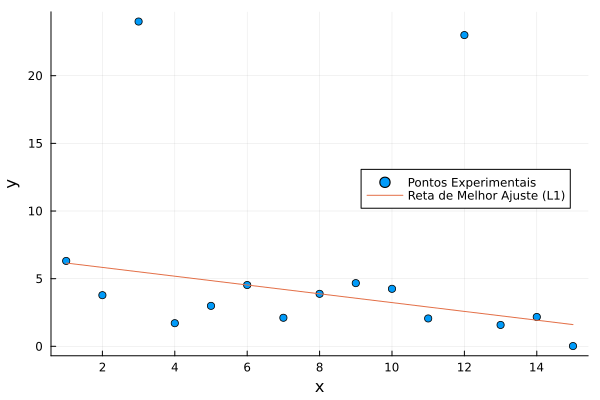

In [93]:
# Problema 3(b)

# A função de custo $L_1$ lida de forma mais robusta com outliers do que o método de mínimos quadrados $L_2$.
# Isso pode ser observado no gráfico resultante,
# onde a reta de melhor ajuste L1 é menos afetada pelos outliers em comparação com a reta de melhor ajuste L2.

# Resistência a Outliers: A função de custo $L_1$ minimiza a soma dos valores absolutos dos resíduos,
# o que a torna menos sensível a valores extremos nos dados.
# Isso significa que os outliers têm menos impacto na determinação dos coeficientes da reta.

# Robustez: O método L1 é mais robusto em situações em que há presença de outliers,
# porque busca o máximo de valores nulos na diferença (dados - dados_ajustados), ao contrário do método L2,
#que minimiza o erro quadrático.

# Impacto Menor nos Parâmetros da Reta: A reta de melhor ajuste L1 é menos influenciada pelos outliers,
# o que resulta em coeficientes da reta (inclinação e interceptação) mais representativos dos dados típicos,
# tornando-a uma escolha melhor para lidar com conjuntos de dados que levantem a suspeita de outliers.

# Portanto, o custo $L_1$ lida melhor com outliers e é uma escolha mais adequada quando a robustez em relação a valores
#extremos é necessária, ao passo que o método de mínimos quadrados $L_2$ é mais sensível a outliers, o que pode
#distorcer a reta de melhor ajuste.

using Plots
using JuMP
using GLPK

# Dados de entrada
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

# Função para calcular os coeficientes 'a' e 'b' pelo método de mínimos quadrados L1
function ajuste_L1(x, y)
    n = length(x)
    A = [x ones(n)]
    model = Model(GLPK.Optimizer)
    @variable(model, a_L1)
    @variable(model, b_L1)
    @variable(model, t[1:n] >= 0)
    @constraint(model, eq[i=1:n], y[i] - a_L1 * x[i] - b_L1 <= t[i])
    @constraint(model, eq2[i=1:n], a_L1 * x[i] + b_L1 - y[i] <= t[i])
    @objective(model, Min, sum(t))
    optimize!(model)
    return value(a_L1), value(b_L1)
end

# Calcula os coeficientes 'a' e 'b' para o ajuste L1
a_L1, b_L1 = ajuste_L1(x, y)

# Calcula os valores previstos pela reta de melhor ajuste L1
y_previsto_L1 = a_L1 * x .+ b_L1

# Plot dos pontos e da reta de melhor ajuste L1
Plots.scatter(x, y, label="Pontos Experimentais", legend=:right)
Plots.plot!(x, y_previsto_L1, label="Reta de Melhor Ajuste (L1)", xlabel="x", ylabel="y")

### Problema 4 (QP): (Continuação do problema anterior)
Outra abordagem é utilizar custo $L_2$ para pontos próximos à reta, porém custo $L_1$ para pontos que estão longes da reta. Especificamente, seguindo o estatístico Huber, define-se a função de custo:
\begin{equation}
\phi(x) =
    \left\{
        \begin{array}{l}
            x^2, \quad \text{if}~-M \leq x \leq M \\
            2M|x| - M^2 \quad \text{senão}
        \end{array}
     \right.
\end{equation}
Embora a fórmula seja simples, ela precisa ser manipulada para que fique no formato de um programa quadrático e convexo, e essa manipulação resulta no seguinte QP convexo:
\begin{equation}
\phi(x) =
    \left\{
        \begin{array}{l}
            \text{minimize}_{v,w}~ w^2 + 2 Mv \\
            \text{sujeito a}~|x| \leq w + v \\
            \qquad v \geq 0, w \leq M
        \end{array}
     \right.
\end{equation}
Utilize $M=1$, e plote a função $\phi(x), -3 \leq x \leq 3$ gerada por ambas as expressões acima e verifique que são, de fato, equivalentes. Finalmente, encontre a reta de melhor ajuste aos dados especificados em Q.1, plotando seu resultado. A função objetivo para esta parte é:
\begin{equation}
\sum_{i=1}^{15} \phi(y_i - ax_i - b)
\end{equation}

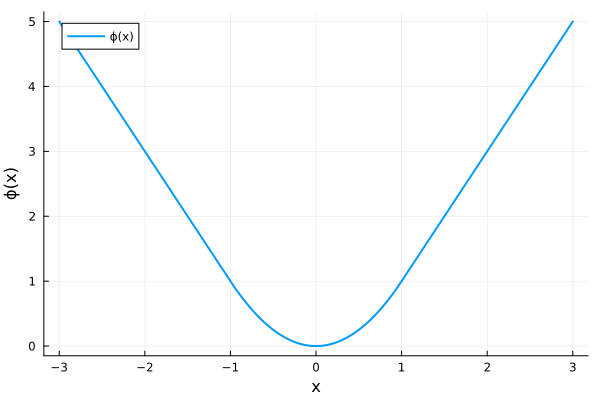

In [94]:
# Problema 4: função phi(x)

using Plots

M = 1
x = -3:0.01:3

# Definir a função phi(x)
function phi(x)
    if -M <= x <= M
        return x^2
    else
        return 2M * abs(x) - M^2
    end
end

phi_values = [phi(x_i) for x_i in x]

plot(x, phi_values, label="ϕ(x)", xlabel="x", ylabel="ϕ(x)", linewidth=2, legend=:topleft)

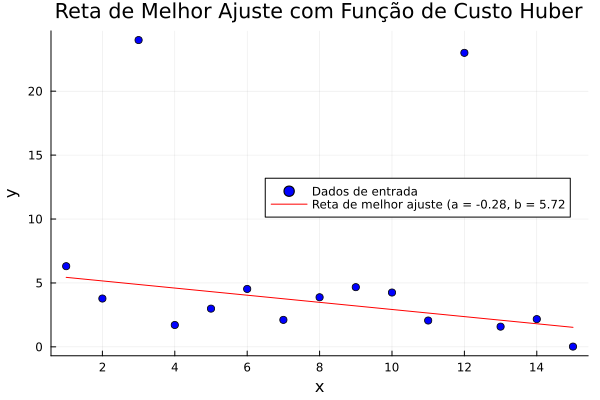

In [96]:
# Problema 4: Reta de melhor ajuste

using JuMP
using NLopt
using Plots

# Dados de entrada
x_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
y_data = [6.31, 3.78, 24, 1.71, 2.99, 4.53, 2.11, 3.88, 4.67, 4.25, 2.06, 23, 1.58, 2.17, 0.02]

# Função de custo Huber
function huber_cost(x, M=1)
    if abs(x) <= M
        return x^2
    else
        return 2M * abs(x) - M^2
    end
end

# Modelo de otimização
model = Model(optimizer_with_attributes(NLopt.Optimizer, "algorithm" => :LN_COBYLA))

@variable(model, a)
@variable(model, b)

# Registrar a função manualmente
register(model, :huber_cost, 1, huber_cost; autodiff = true)

@NLobjective(model, Min, sum(huber_cost(y_data[i] - a * x_data[i] - b) for i in 1:length(x_data)))

# Resolvendo o problema de otimização
optimize!(model)

# Parâmetros otimizados da reta de melhor ajuste
a_opt = value(a)
b_opt = value(b)

# Gerar pontos para a reta de melhor ajuste
x_fit = range(1, stop = 15, length = 100)
y_fit = a_opt * x_fit .+ b_opt

# Plotar os resultados
Plots.scatter(x_data, y_data, label="Dados de entrada", color="blue")
Plots.plot!(x_fit, y_fit, label="Reta de melhor ajuste (a = $(round(a_opt, digits=2)), b = $(round(b_opt, digits=2))", color="red",
    legend=:right)
Plots.xlabel!("x")
Plots.ylabel!("y")
Plots.title!("Reta de Melhor Ajuste com Função de Custo Huber")

### Problema 5 (Compromisso [tradeoff])
Deseja-se enviar uma sequência de entradas (tensões) ao manipulador do braço de um robô. Os dados se encontram no arquivo *voltages.csv* e estão plotados abaixo.

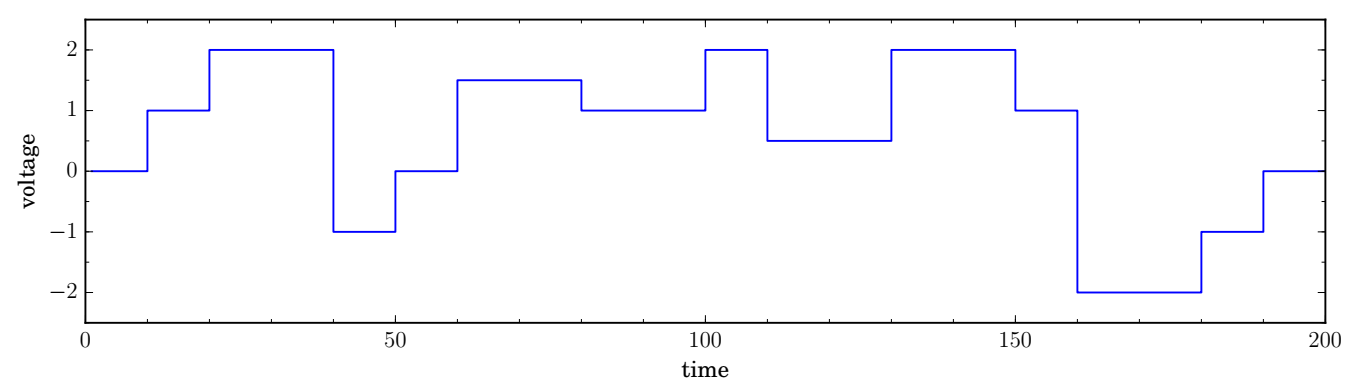

Mudanças bruscas (que ocorrem no gráfico das tensões mostrado acima) danificam os motores do manipulador, portanto deseja-se suavizar as transições (saltos) no sinal. Denotando as tensões por $v_i, i = 1, 2, \ldots, 200$, uma maneira de caracterizar suavidade do sinal é através da soma das diferenças ao quadrado:
\begin{equation}
    R(v) = (v_2 - v_1)^2 + (v_3 - v_2)^2 + \cdots + (v_{200} - v_{199})^2
\end{equation}
Quanto menor $R(v)$, mais suave o sinal. Formule e resolva um problema de mínimos quadrados regularizado que equilibra os dois objetivos de aproximar o sinal mostrado no gráfico acima, porém também impor um certo grau de suavidade. Explique seu raciocínio ao formular o modelo e inclua um gráfico comparando as tensões desejadas com as tensões suavizadas que você gerou através do seu modelo de mínimos quadrados regularizado.

In [1]:
voltages = [
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1.5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-2
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
0
0
0
0
0
0
0
0
0]

200-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
 -1.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

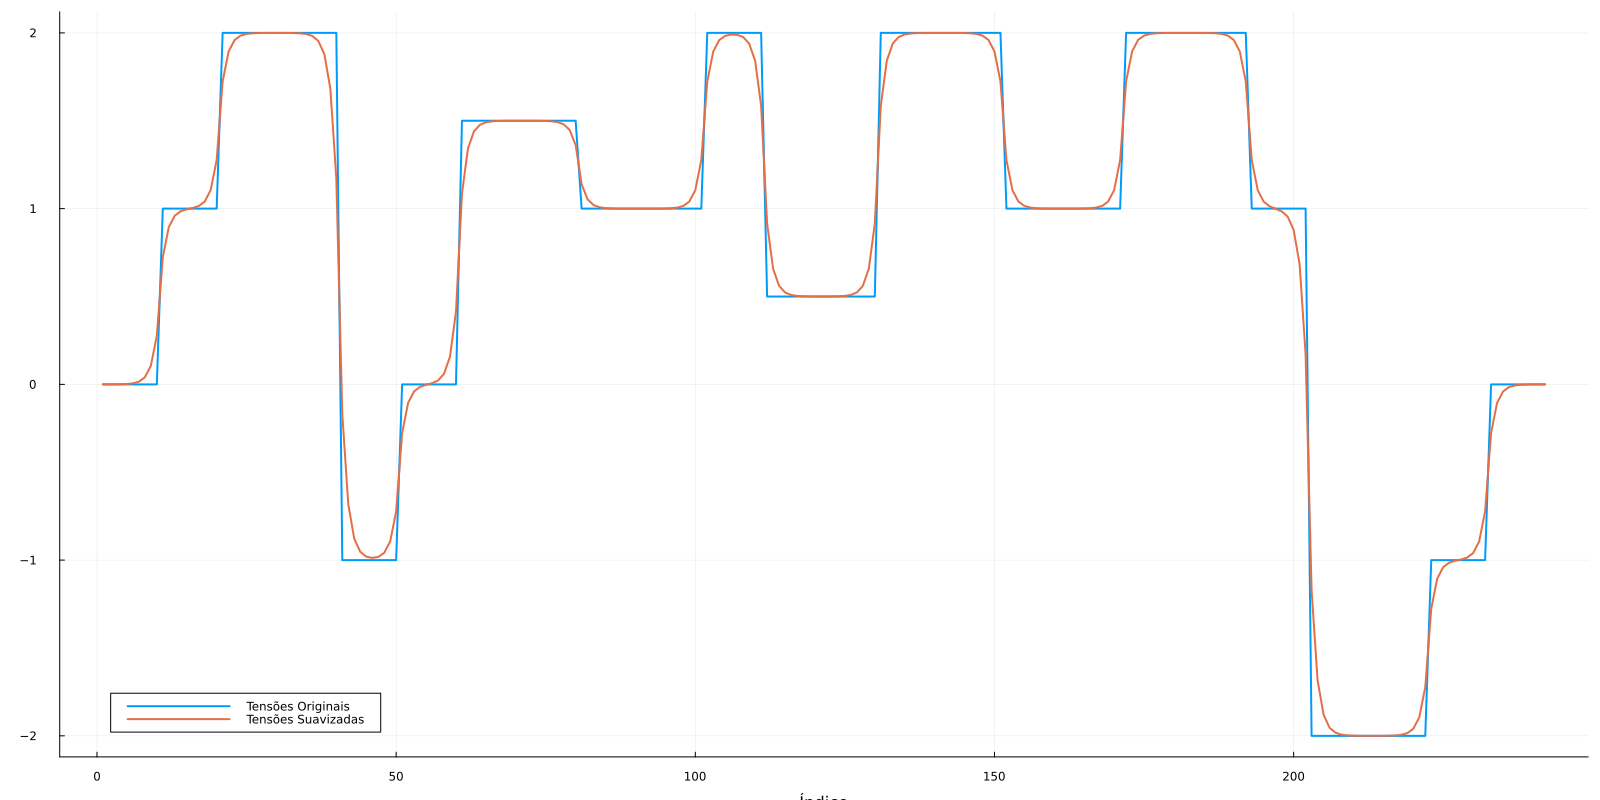

In [63]:
using JuMP
using Ipopt
using Plots

# Supondo que 'voltages' seja um vetor contendo os dados
voltages = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
            1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
            1.5, 1.5, 1.5, 1.5, 1.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0.5, 0.5, 
            0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
            0.5, 0.5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
            1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -2, -2, -2, -2, -2, -2, -2, -2, 
            -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, 
            -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Criar o modelo de otimização
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Número de pontos
n = length(voltages)

# Variáveis de decisão
@variable(model, v[1:n])

# Função objetivo
λ = 1  # Ajuste conforme necessário
@objective(model, Min, sum((v[i] - voltages[i])^2 for i in 1:n) + λ * sum((v[i+1] - v[i])^2 for i in 1:n-1))

# Restrições
@constraint(model, v[1] == voltages[1])
@constraint(model, v[n] == voltages[n])

# Resolver o modelo
optimize!(model)

# Extrair a solução otimizada
v_smooth = value.(v)

# Plotar os resultados com um gráfico maior
plot(voltages, label="Tensões Originais", xlabel="Índice", ylabel="Tensão", linewidth=2, size=(1600, 800))
plot!(v_smooth, label="Tensões Suavizadas", linewidth=2)

O problema foi modelado para que ajustasse os dados de acordo com o método dos mínimos quadrados e penalizasse mudanças bruscas em valores adjacentes com o fator $\lambda$. Variando o regularizador $\lambda$ encontram-se soluções que priorizem o ajuste de minimos quadrados quando $ \lim_{{\lambda \to 0}}$, ou a suavidade dos dados no caso $\lim_{{\lambda \to \infty}}$

### Problema 6 (variáveis binárias): 

Resolva o problema abaixo com variáveis de decisão reais $x_1,x_2 \in {\mathbb{R}}$, usando _qualquer método consistente_ . O símbolo $\vee$ denota o operador lógico OU <b>não exclusivo</b>, e a equação descrevendo as restrições significa que vale OU grupo 1 (as três restrições entre o primeiro par de parênteses), OU grupo 2 (as três restrições entre o segundo par de parênteses) OU grupo 3 (as três restrições entre o terceiro par de parênteses).
$$
	\min_{x_1,x_2}\;  x_1 + 3x_2 
$$
sujeito a:
$$
\left(
\begin{array}{c}
2x_1 - x_2 \geq  -3\\-x_1 + x_2 \geq 2 \\ x_1 \geq 0
\end{array}
\right)
\vee
\left(
\begin{array}{c}
4x_1 - 2x_2 \geq  4\\-2x_1 + 2x_2 \geq -2 \\ x_1 +x_2 \geq 2
\end{array}
\right)
\vee
\left(
\begin{array}{c}
6x_1 - 3x_2 \geq  0\\-3x_1 + 3x_2 \geq 1 \\ 2x_1 + 3x_2 \geq 3
\end{array}
\right)
$$
O problema é convexo? Reformule como MILP.


<b>Sugestão</b>: Para a reformulação MILP introduza variáveis binárias $\delta_i$, $i=1,2,3$, para cada conjunto de restrições (entre parênteses). Ou seja, se escrever as restrições como $P$ ou $Q$ ou $R$, associa-se $\delta_1$ a $P$, $\delta_2$ a $Q$ e $\delta_3$ a $R$.


In [59]:
using JuMP, Cbc

function problema()
    model = Model(Cbc.Optimizer)

    @variable(model, x1 >= 0)
    @variable(model, x2)
    @variable(model, delta[1:3], binary=true)

    @objective(model, Min, x1 + 3x2)

    # Restrições para o grupo 1
    @constraint(model, 2x1 - x2 + delta[1]*(-3) >= 0)
    @constraint(model, -x1 + x2 + delta[1]*(-2) >= 0)
    @constraint(model, x1 + delta[1]*(-1) >= 0)

    # Restrições para o grupo 2
    @constraint(model, 4x1 - 2x2 + delta[2]*(-4) >= 0)
    @constraint(model, -2x1 + 2x2 + delta[2]*(2) >= 0)
    @constraint(model, x1 + x2 + delta[2]*(-2) >= 0)

    # Restrições para o grupo 3
    @constraint(model, 6x1 - 3x2 + delta[3]*(0) >= 0)
    @constraint(model, -3x1 + 3x2 + delta[3]*(-1) >= 0)
    @constraint(model, 2x1 + 3x2 + delta[3]*(-3) >= 0)

    # Apenas um grupo de restrições pode ser ativo
    @constraint(model, sum(delta) == 1)

    optimize!(model)

    println("Status da otimização: ", termination_status(model))
    println("x1 = ", value(x1))
    println("x2 = ", value(x2))
    println("delta = ", value.(delta))
    println("Valor ótimo da função objetivo: ", objective_value(model))
end

problema()


Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 2.46316 - 0.00 seconds
Cgl0004I processed model has 10 rows, 5 columns (3 integer (3 of which binary)) and 28 elements
Cbc0038I Initial state - 3 integers unsatisfied sum - 0.105263
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 2.625 iterations 2
Cbc0038I Solution found of 2.625
Cbc0038I Relaxing continuous gives 2.6
Cbc0038I Before mini branch and bound, 0 integers at bound fixed and 0 continuous
Cbc0038I Full problem 10 rows 5 columns, reduced to 9 rows 5 columns
Cbc0038I Mini branch and bound did not improve solution (0.01 seconds)
Cbc0038I Round again with cutoff of 2.58631
Cbc0038I Pass   2: suminf.    0.01053 (2) obj. 2.58631 iterations 2
Cbc0038I Pass   3: suminf.    0.20511 (3) obj. 2.58631 iterations 3
Cbc0038I Pass   4: suminf.    0.01053 (2) obj. 2.58631 iterations 3
Cbc0038I Pass   5: suminf.    0.20511 (3

# Problema 7 (QP, formulação matemática)

(<i>Localização ótima de um helicóptero de resgate</i>) Sejam $(x,y)$ as coordenadas da base de um helicóptero de resgate e $(0,0), (5,-1), (4,6), (1,3)$ as coordenadas dos pontos nos quais o helicóptero tem que buscar vítimas (= pontos de resgate), mais rapidamente possível. Supondo que o helicóptero sempre se desloca numa velocidade constante, formule como problema de otimização, especificando claramente a função objetivo <b>[1.0 ponto]</b>, variáveis de decisão <b>[0.5 pontos]</b>, e restrições <b>[0.5 pontos]</b>. Encontre a solução numérica, utilizando JuMP <b>[bônus de 1 ponto]</b>. 

_Sugestão_: É preciso minimizar a máxima distância entre a base e os pontos de resgate. Ou seja,  todos os pontos de resgate devem estar dentro do raio de ação helicóptero,  e deseja-se minimizar este raio.

### Formulação Matemática:

**Variáveis de Decisão:**
- Utilizando $x_b$ e $y_b$ como coordenadas da base do helicóptero de resgate.

**Função Objetivo:**
- Minimizar o raio de ação do helicóptero, representado pela distância máxima entre a base do helicóptero e qualquer ponto de resgate. A função objetivo pode ser formulada como:
  $$ \text{Min} \quad r $$
  onde $r$ é o raio de ação do helicóptero, e $r$ = max\{distância até o ponto de resgate\}.

**Restrições:**
- As coordenadas dos pontos de resgate \((0,0), (5,-1), (4,6), (1,3)\) devem estar dentro do raio de ação do helicóptero. A distância entre a base do helicóptero e cada ponto de resgate deve ser menor ou igual ao raio de ação \(r\):
  $$ \sqrt{(x_b - 0)^2 + (y_b - 0)^2} \leq r $$
  $$ \sqrt{(x_b - 5)^2 + (y_b - (-1))^2} \leq r $$
  $$ \sqrt{(x_b - 4)^2 + (y_b - 6)^2} \leq r $$
  $$ \sqrt{(x_b - 1)^2 + (y_b - 3)^2} \leq r $$
- As coordenadas do helicóptero devem estar dentro de uma área restrita. Isso pode ser limitado por um retângulo que engloba todos os pontos de resgate, garantindo que a base do helicóptero esteja em uma posição realista em relação aos pontos de resgate.

In [40]:
using JuMP, Ipopt

# Pontos de resgate
rescue_points = [(0, 0), (5, -1), (4, 6), (1, 3)]

# Modelo de otimização
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model, "print_level", 0)

# Variáveis de decisão
@variable(model, x)
@variable(model, y)
@variable(model, r >= 0)  # Raio de ação do helicóptero

# Função objetivo: Minimizar o raio de ação
@objective(model, Min, r)

# Restrições
for point in rescue_points
    @constraint(model, (x - point[1])^2 + (y - point[2])^2 <= r^2)
end

# Otimização
optimize!(model)

# Coordenadas ótimas do helicóptero
x_optimal = value(x)
y_optimal = value(y)

# Raio de ação ótimo
r_optimal = value(r)

println("Coordenadas ótimas: ($x_optimal, $y_optimal)")
println("Raio de ação ótimo: $r_optimal")

Coordenadas ótimas: (3.0588235002851993, 2.294117622449074)
Raio de ação ótimo: 3.823529380637718


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


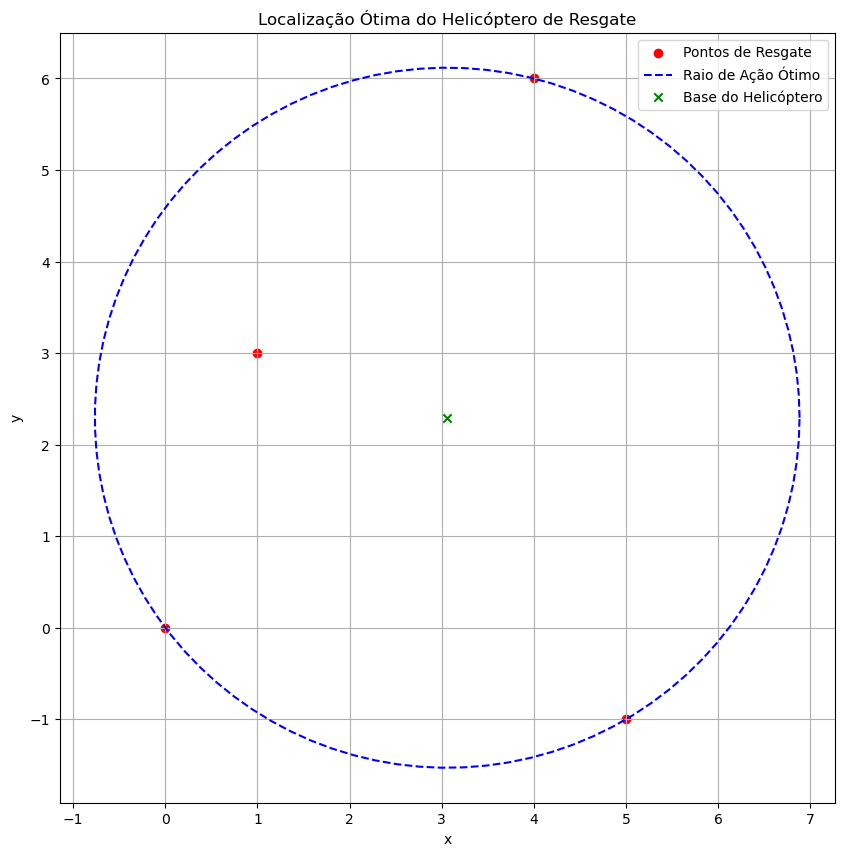

In [44]:
using PyPlot

# Pontos de resgate
rescue_points = [(0, 0), (5, -1), (4, 6), (1, 3)]

# Coordenadas ótimas do helicóptero e raio de ação ótimo
x_optimal = value(x)
y_optimal = value(y)
r_optimal = value(r)

# Gerar pontos para desenhar o círculo representando o raio de ação
theta = range(0, stop=2π, length=100)
circle_x = x_optimal .+ r_optimal * cos.(theta)
circle_y = y_optimal .+ r_optimal * sin.(theta)

# Plotar a região do problema
figure(figsize=(10, 10))
plt.scatter([point[1] for point in rescue_points], [point[2] for point in rescue_points], label="Pontos de Resgate", color="red")
plt.plot(circle_x, circle_y, label="Raio de Ação Ótimo", color="blue", linestyle="--")
plt.scatter(x_optimal, y_optimal, label="Base do Helicóptero", color="green", marker="x")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Localização Ótima do Helicóptero de Resgate")
plt.grid(true)
plt.show()


### Problema 8 (MA, AR, ARMA via mínimos quadrados)

There are many ways to model the relationship between an input sequence $\{u_1, u_2,\dots\}$ and an output sequence $\{y_1, y_2,\dots\}$. In class, we saw the moving average (MA) model, where each output is approximated by a linear combination of the k most recent inputs:
$$ \text{MA:}\quad y_t \approx b_1u_t + b_2u_{t-1} + \dots + b_ku_{t-k+1} $$

We then used least-squares to find the coefficients $b_1,\dots, b_k$. What if we didn’t have access to the inputs at all, and we were asked to predict future y values based only on the previous y values? One way to do this is by using an autoregressive (AR) model, where each output is approximated by a linear combination of the $\ell$ most recent outputs (excluding the present one):
$$ \text{AR:}\quad y_t \approx a_1y_{t-1} + a_2y_{t-2} + \dots + a_\ell y_{t-\ell} $$

Of course, if the inputs contain pertinent information, we shouldn’t expect the AR method to outperform the MA method!

a) Using the same dataset from class uy_data.csv, plot the true y, and on the same axes, also plot the estimated $\hat y$ using the MA model and the estimated $\hat y$ using the AR model. Use $k = 5$ for both models. To quantify the difference between estimates, also compute $\|y - \hat h\|$ for both cases.

b) Yet another possible modeling choice is to combine both AR and MA. Unsurprisingly, this is called the autoregressive moving average (ARMA) model:
$$ \text{ARMA:}\quad y_t \approx a_1y_{t-1} + a_2y_{t-2} + \dots + a_\ell y_{t-\ell} + b_1u_t + b_2u_{t-1} + \dots + b_ku_{t-k+1} $$

Solve the problem once more, this time using an ARMA model with $k = \ell = 1$. Plot $y$ and $\hat y$ as before, and also compute the error $\|y - \hat y\|$.

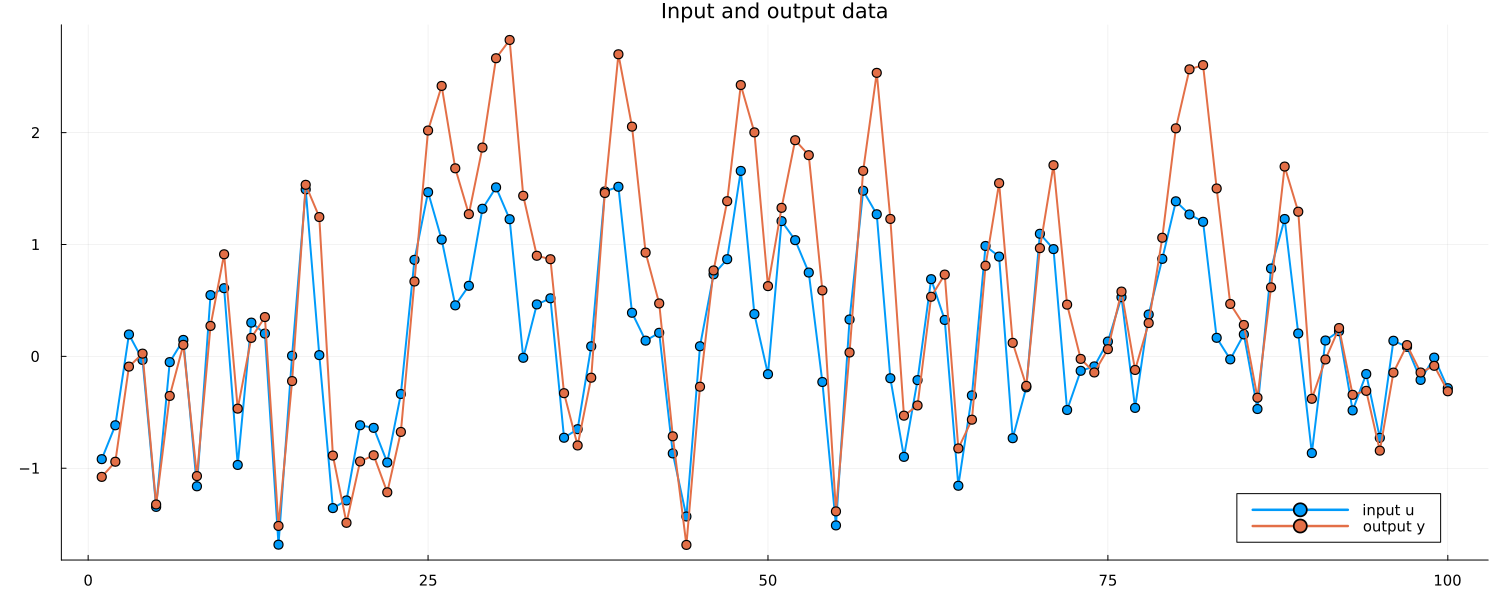

In [51]:
raw = [-0.9188 -1.0773
-0.6159 -0.9419
0.1959 -0.0915
-0.0316 0.0245
-1.3455 -1.3239
-0.0513 -0.3536
0.1471 0.1032
-1.1615 -1.0702
0.5478 0.2722
0.6096 0.9127
-0.9706 -0.4672
0.3018 0.1654
0.2039 0.3515
-1.6833 -1.5158
0.0057 -0.2207
1.4925 1.5337
0.0113 1.2458
-1.3563 -0.8868
-1.288 -1.488
-0.6159 -0.9394
-0.639 -0.884
-0.9488 -1.2152
-0.3364 -0.6755
0.8631 0.6695
1.4679 2.0192
1.0442 2.4178
0.4562 1.6812
0.6309 1.2713
1.3197 1.8668
1.5108 2.6653
1.2262 2.8286
-0.0127 1.4358
0.4645 0.8995
0.5191 0.8685
-0.7274 -0.3292
-0.6509 -0.7965
0.0901 -0.1906
1.4747 1.4607
1.5163 2.7007
0.3898 2.0539
0.1405 0.9278
0.2109 0.4734
-0.8675 -0.7146
-1.4313 -1.6855
0.0905 -0.2711
0.7334 0.7681
0.8687 1.3874
1.658 2.4258
0.3784 2.0024
-0.1594 0.6279
1.2091 1.3279
1.0389 1.9324
0.7494 1.7987
-0.229 0.5894
-1.5111 -1.3858
0.3298 0.0347
1.481 1.6587
1.2702 2.5347
-0.1956 1.2286
-0.8984 -0.53
-0.2123 -0.4387
0.6902 0.5329
0.3256 0.7312
-1.1566 -0.823
-0.349 -0.5661
0.9869 0.8105
0.892 1.5486
-0.7315 0.1209
-0.2765 -0.2639
1.0961 0.9674
0.959 1.7094
-0.4793 0.4625
-0.129 -0.0227
-0.0896 -0.1439
0.1326 0.0645
0.5292 0.5793
-0.4606 -0.1214
0.3742 0.298
0.8715 1.0606
1.3862 2.0386
1.2687 2.5662
1.203 2.6041
0.166 1.5009
-0.0269 0.4687
0.1963 0.2807
-0.4706 -0.3694
0.7855 0.617
1.2281 1.6969
0.205 1.2934
-0.8645 -0.3791
0.1419 -0.0276
0.2251 0.2533
-0.4831 -0.3436
-0.1577 -0.3082
-0.7281 -0.8429
0.1397 -0.1449
0.0851 0.1008
-0.2105 -0.1442
-0.011 -0.0843
-0.2845 -0.3122]

u = raw[:,1];
y = raw[:,2];
T = length(u)

using Plots

# Ajuste da estética
plot([u y], label=["input u" "output y"], legend=:bottomright, size=(1500, 600), xlabel="Time", ylabel="Values", linewidth=2, marker=:circle, markersize=5, titlefontsize=14, legendfontsize=10, tickfontsize=10, guidefontsize=12)
title!("Input and output data")

The norm of the error using AR is: 7.436691765656793


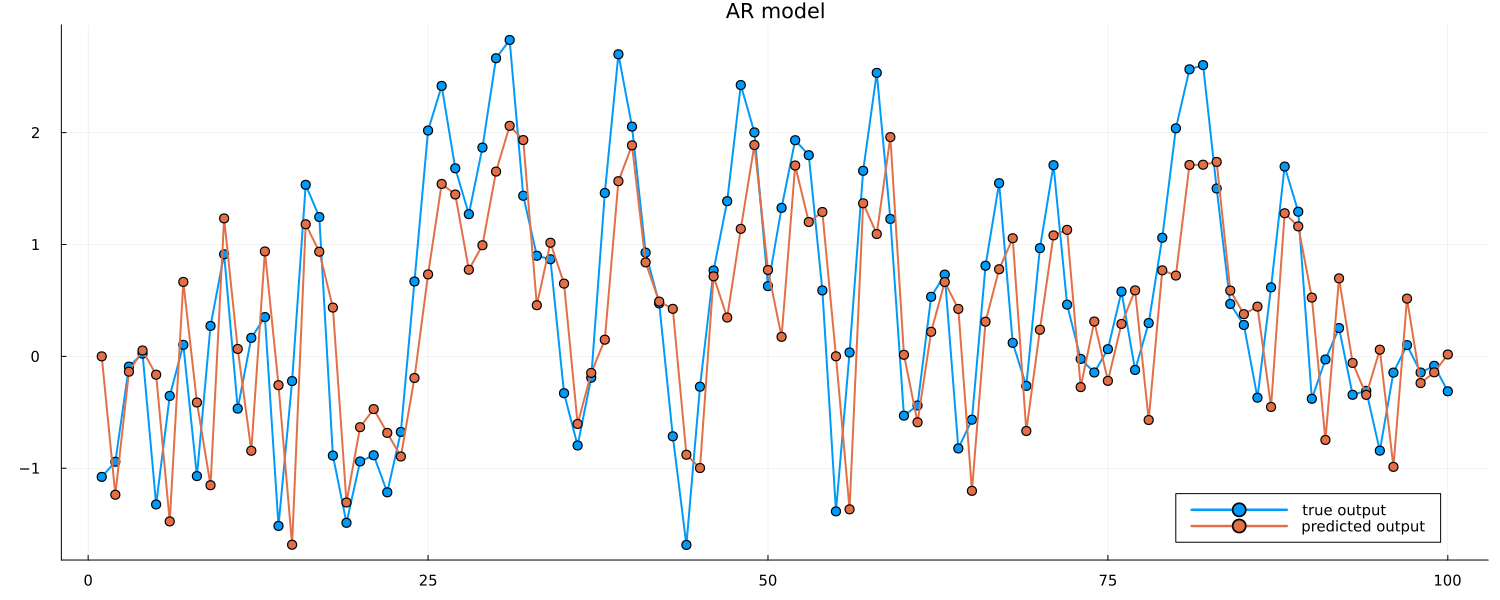

In [54]:
using Plots

# generate A matrix. Using more width creates a better fit. (AR model)
width = 5
A = zeros(T, width)

for i = 1:width
    A[i+1:end, i] = y[1:end-i]
end

wopt = A \ y
yest = A * wopt

println("The norm of the error using AR is: ", norm(yest - y))

# Criar um gráfico e adicionar curvas
plot([y yest], label = ["true output" "predicted output"], legend=:bottomright, size=(1500, 600), xlabel="Time", ylabel="Values", linewidth=2, marker=:circle, markersize=5, titlefontsize=14, legendfontsize=10, tickfontsize=10, guidefontsize=12)
xlabel!("Time")
ylabel!("Output")
title!("AR model")

The norm of the error using MA is: 2.460854388269911


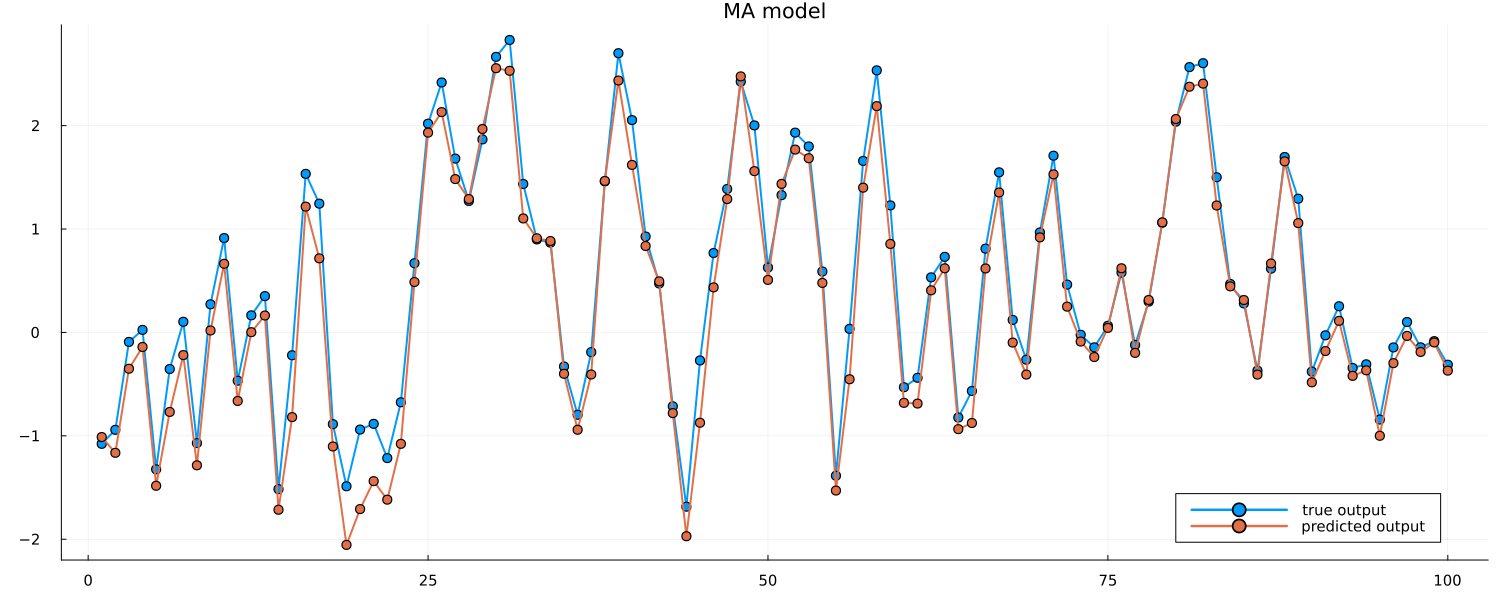

In [55]:
using Plots

T = length(u)
width = 5
A = zeros(T, width)

for i = 1:width
    A[i:end, i] = u[1:end-i+1]
end

wopt = A \ y
yest = A * wopt

println("The norm of the error using MA is: ", norm(yest - y))

# Criar um gráfico e adicionar curvas com estética ajustada
plot([y yest], label = ["true output" "predicted output"], legend=:bottomright, size=(1500, 600), xlabel="Time", ylabel="Values", linewidth=2, marker=:circle, markersize=5, titlefontsize=14, legendfontsize=10, tickfontsize=10, guidefontsize=12)
xlabel!("Time")
ylabel!("Output")
title!("MA model")

The norm of the error using ARMA is: 1.8565828148734604


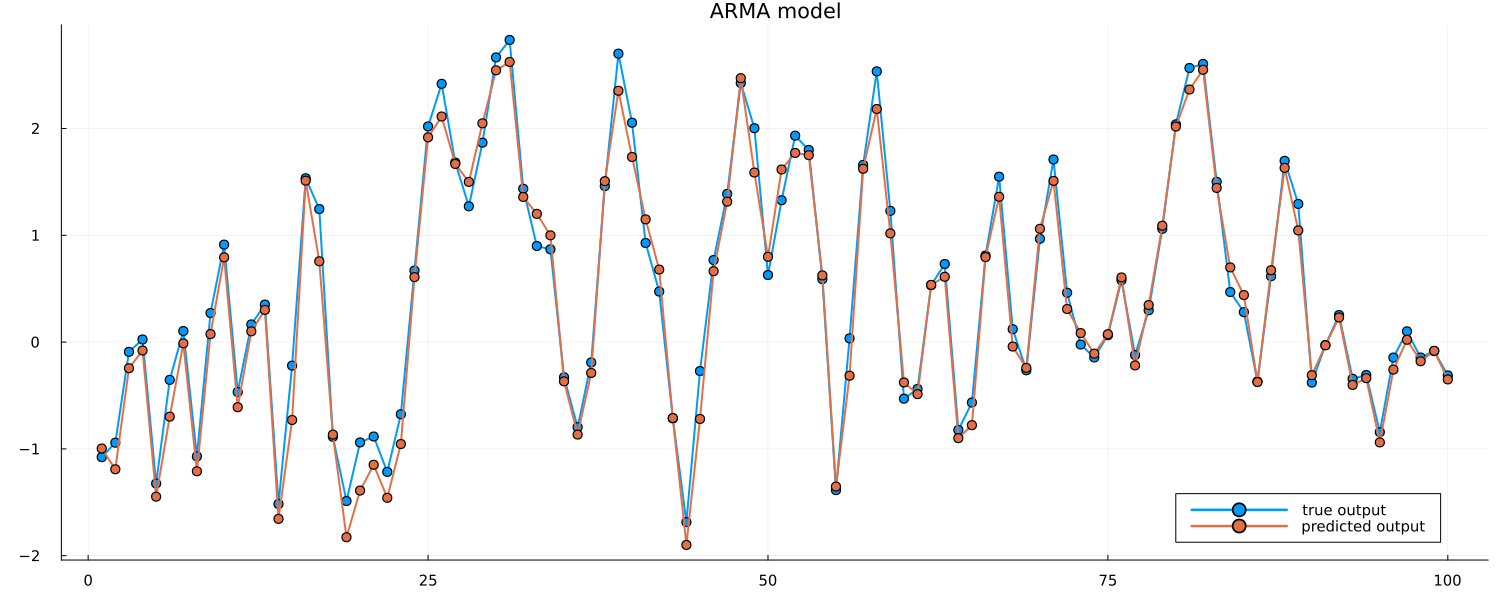

In [56]:
using Plots

# generate A matrix. Using more width creates a better fit. (ARMA model)
w1 = 1
w2 = 1
A = zeros(T, w1 + w2)

for i = 1:w1
    A[i:end, i] = u[1:end-i+1]
end

for i = 1:w2
    A[i+1:end, w1+i] = y[1:end-i]
end

wopt = A \ y
yest = A * wopt

println("The norm of the error using ARMA is: ", norm(yest - y))

# Criar um gráfico e adicionar curvas
plot([y yest], label = ["true output" "predicted output"], legend=:bottomright, size=(1500, 600), xlabel="Time", ylabel="Values", linewidth=2, marker=:circle, markersize=5, titlefontsize=14, legendfontsize=10, tickfontsize=10, guidefontsize=12)
xlabel!("Time")
ylabel!("Output")
title!("ARMA model")

### Problema 8 (SOCP)
A **mediana geométrica** de um conjunto de pontos $x_i, i = 1,\ldots , k$ em $R^2$ é o ponto $x$ que minimiza a soma das distâncias Euclideanas aos pontos $x_i$, Escreva o problema de encontrar a mediana geométrica de $k$ pontos em $R^2$ como um programa cônico de segunda ordem (SOCP).


A formulação do SOCP é a seguinte:

A formulação do problema é:
 $$\min_{x} \sum_1^k ||x-x_i||_2$$

Seja $\mathbf{1}_k$ um vetor de 1s $\in R^k$, i.a., $1_k$ = (1,...,1) $\in R^k$.

Seja $t \in R^k$ um vetor de variáveis de decisão, onde as variaveis individuais $t_i$ são não-negativas, $t_i \geq  0$.


Então, esta formulação pode ser reescrita em termos de um problema SOCP:

$$\min_{x,t} \mathbf{1}^T t\\
 \text{s.a.}~~||x-x_i||_2 \le t_i \quad i = 1,2, \dots ,k$$

### Problema 9 (NLLS: mínimos quadrados nãolineares)

A series of experiments is conducted to determine the effect of a particular fertilizer on wheat crop yield. Here are the results:

|fertilizer rate ($x$) |	crop yield ($y$) |
|----------------------|---------------------|
|-5 |	127 |
|-3 |	151 |
|-1 |	379
|1 	| 421 |
|3 |	460 |
|5 |	426 |

Such situations typically involve some sort of diminishing returns. So there is a limit to how much the fertilizer can boost the yield. A popular model for this relationship is the following:
$$y=k_1+ k_2 \exp(k_3 x)$$

Use nonlinear least squares to determine the values of $(k_1,k_2,k_3)$
that provide the best fit to the data. We are expecting coefficients in the neighborhood of $(500,-200,-1)$. To display your result, produce a plot of the original data points and the best-fit curve.

Parâmetros Ajustados:
k1 = 523.3055369153885
k2 = -156.94784149313074
k3 = -0.19966457098386536


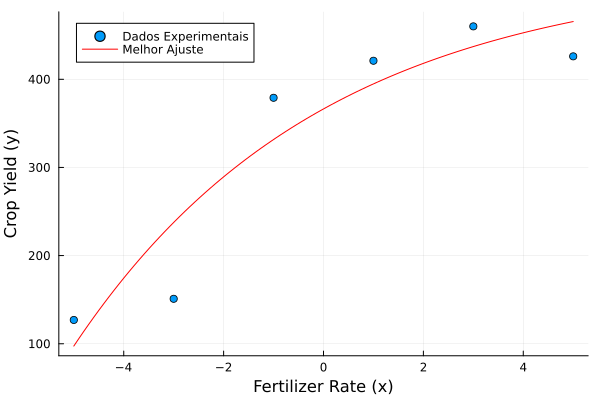

In [37]:
using LsqFit
using Plots

# Dados experimentais (definidos como Float64)
x_data = [-5.0, -3.0, -1.0, 1.0, 3.0, 5.0]
y_data = [127.0, 151.0, 379.0, 421.0, 460.0, 426.0]

# Modelo não linear
model_nonlinear(x, params) = params[1] .+ params[2] .* exp.(params[3] .* x)

# Estimativas iniciais para os parâmetros
initial_params = [500.0, -200.0, -1.0]

# Ajuste dos dados ao modelo utilizando mínimos quadrados não lineares
fit = curve_fit(model_nonlinear, x_data, y_data, initial_params)

# Parâmetros ajustados
best_fit_params = coef(fit)

# Gerar pontos para a melhor curva ajustada
x_fit = range(-5, stop = 5, length = 100)
y_fit = model_nonlinear(x_fit, best_fit_params)

# Exibir os parâmetros ajustados
println("Parâmetros Ajustados:")
println("k1 = ", best_fit_params[1])
println("k2 = ", best_fit_params[2])
println("k3 = ", best_fit_params[3])

# Plotar os resultados
Plots.scatter(x_data, y_data, label="Dados Experimentais", legend=:topleft)
Plots.plot!(x_fit, y_fit, label="Melhor Ajuste", color="red")
Plots.xlabel!("Fertilizer Rate (x)")
Plots.ylabel!("Crop Yield (y)")